# 0. Import libraries
## 0.1. Import public libraries

In [13]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns


This notebook was made with celloracle version 0.10.5.
**Please use celloracle>=0.10.1** Otherwise, you may get an error.

In [14]:
import celloracle as co
co.__version__

'0.10.8'

In [15]:
#plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [6,6]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 600

%matplotlib inline

## 0.1. Make a folder to save graph

In [60]:
# Make folder to save plots
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data
## 1.1. Load processed oracle object

Load the oracle object. See the previous notebook for information on initializing an `Oracle` object.

In [16]:
oracle = co.load_hdf5("./Myeloid.celloracle.oracle")

## 1.2. Load inferred GRNs

In the previous notebook, we calculated the GRNs. Now, we will use these GRNs for the perturbation simulations. First, we will import the GRNs from the `Links` object.

In [17]:
links = co.load_hdf5("./links_myeloid_cell.type.celloracle.links")

# 2. Make predictive models for simulation

Here, we will need to fit the ridge regression models again. This process will take less time than the GRN inference in the previous notebook, because we are using the filtered GRN models.

In [18]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, 
                              use_cluster_specific_TFdict=True)

  0%|          | 0/9 [00:00<?, ?it/s]

# 3. In silico TF perturbation analysis

Next, we will simulate the TF perturbation effects on cell identity to investigate its potential functions and regulatory mechanisms. Please see the CellOracle paper for more details on scientific rationale.

In this notebook, we will simulate the knockout of the Gata1 gene in the hematopoiesis trajectory.

Previous studies have shown that Gata1 is one of the TFs that regulates cell fate decisions in myeloid progenitors. Additionally, Gata1 has been shown to affect erythroid cell differentiation.

Here, we will use CellOracle to analyze Gata1 and attempt to recapitulate the previous findings from above.


## 3.1. Check gene expression pattern.

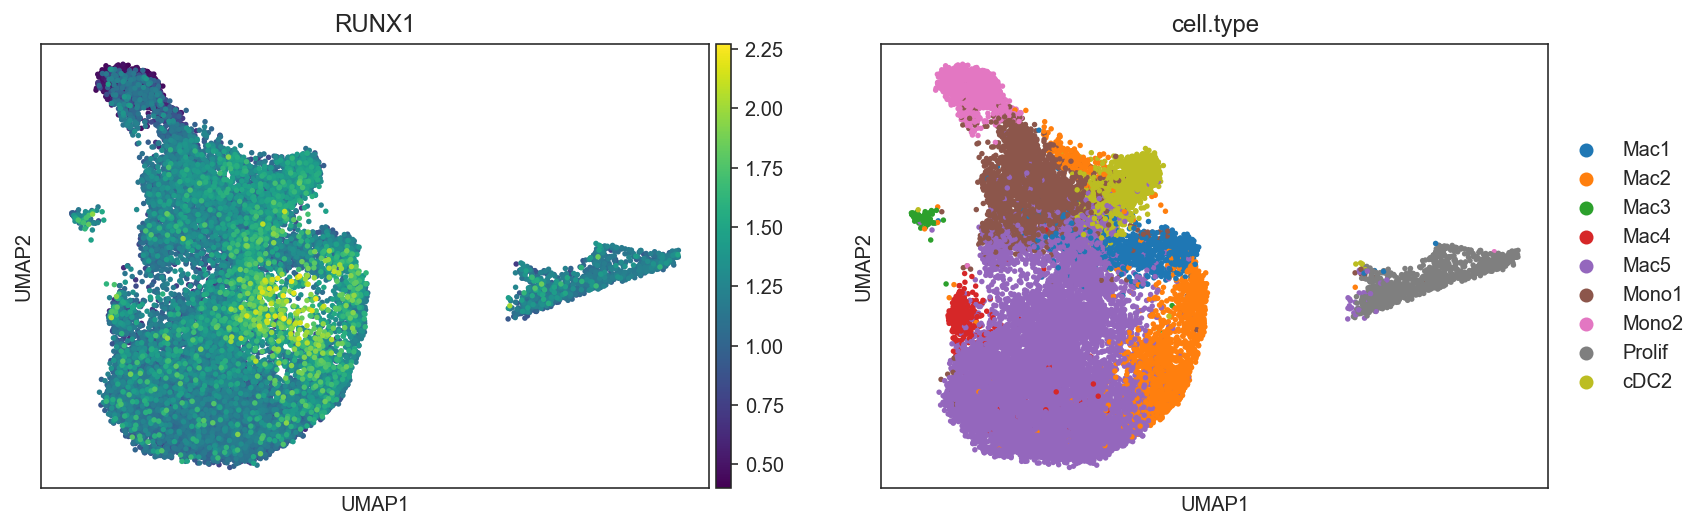

In [19]:
# Check gene expression 
goi = "RUNX1"
sc.pl.umap(oracle.adata, color=[goi, oracle.cluster_column_name], s=30,
                 layer="imputed_count", use_raw=False, cmap="viridis")

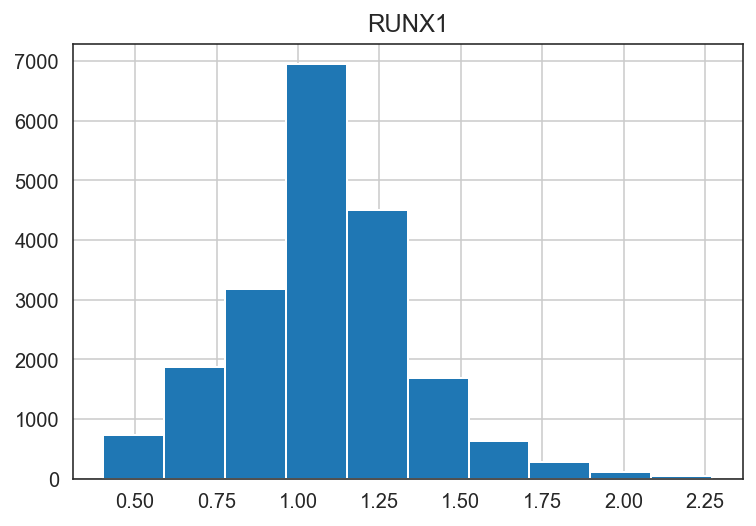

In [20]:
# Plot gene expression in histogram
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

## 3.2. Calculate future gene expression after perturbation.

- You can use any gene expression value in the in silico perturbations, but please avoid extremely high values that are far from the natural gene expression range. The upper limit allowed is twice the maximum gene expression.


To simulate Gata1 KO, we will set Gata1 expression to 0.

In [21]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

In [22]:
#oracle.evaluate_simulated_gene_distribution_range()

## 3.3. Calculate transition probability between cells

- The steps above simulated tge global future gene expression shift after perturbation. This prediction is based on iterative calculations of signal propagation calculations within the GRN. Please look at our paper for more information.

- The next step calculates the probability of cell state transitions based on the simulation data. You can use the transition probabilities between cells to predict how cells will change after a perturbation.

- This transition probability will be used later.


In [23]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True, 
                                sampled_fraction=0.2)

# Calculate embedding 
oracle.calculate_embedding_shift(sigma_corr=0.05)

# 4. Visualization
## 4.1. Quiver plot: Show the direction of cell transition at single cell resolution

### Caution: It is very important to find the optimal `scale` parameter.

- We will need to adjust the `scale` parameter. Please seek to find the optimal `scale` parameter for the data based on your data.

- If the vectors are not visible, you can try a smaller `scale` parameter to magnify the vector length. However, if you see large vectors in the randomized results (right panel), it means that the scale parameter is too small.


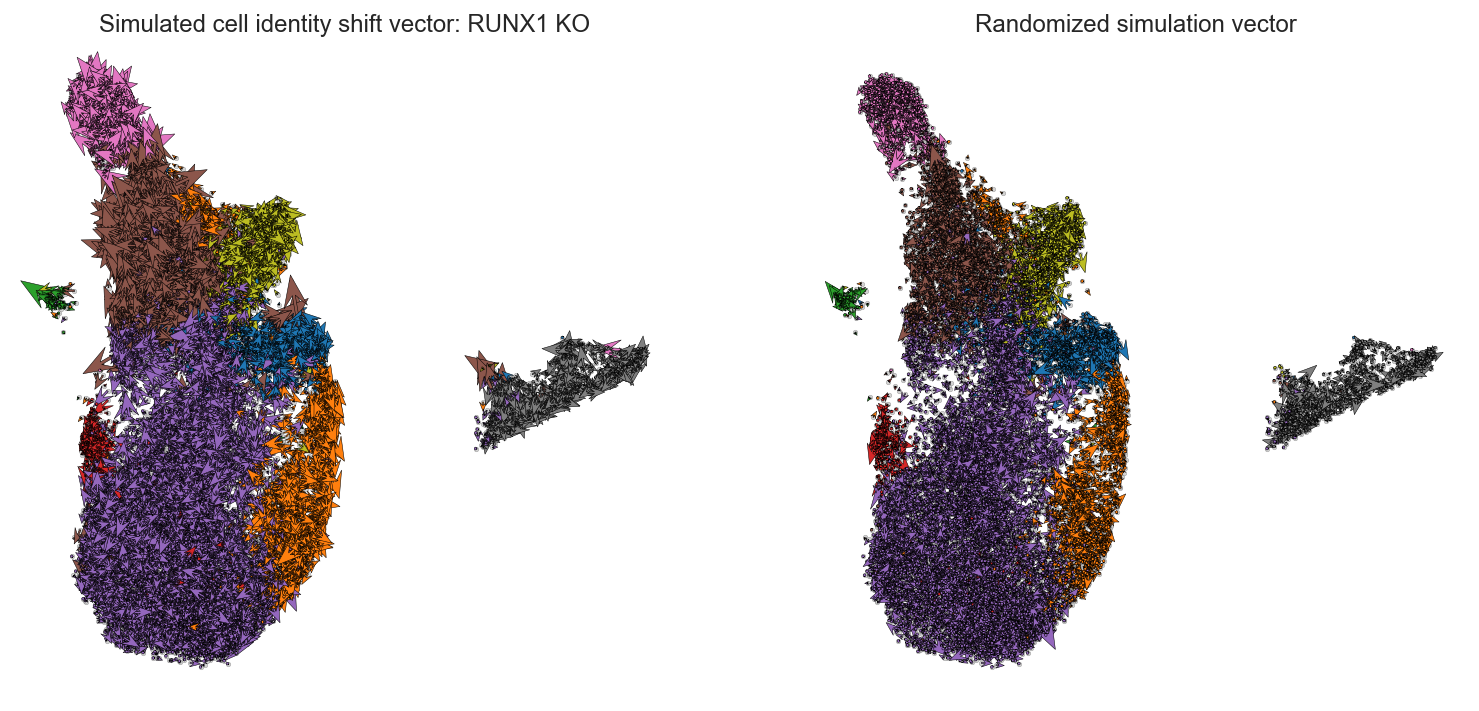

In [24]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 25
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

## 4.2. Vector field graph

We will visualize the simulation results as a vector field on a digitized grid. Single cell transition vectors are grouped by grid point.

### 4.2.1  Find parameters for n_grid and min_mass
`n_grid`: Number of grid points.

`min_mass`: Threshold value for the cell density. 
The appropriate values for these parameters depends on the data. Please find appropriate values using the helper functions below.
 


In [25]:
# n_grid = 40 is a good starting value.
n_grid = 40 
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

Please run `oracle.suggest_mass_thresholds()` to display a range of `min_mass` parameter values and choose a value to fit the data.

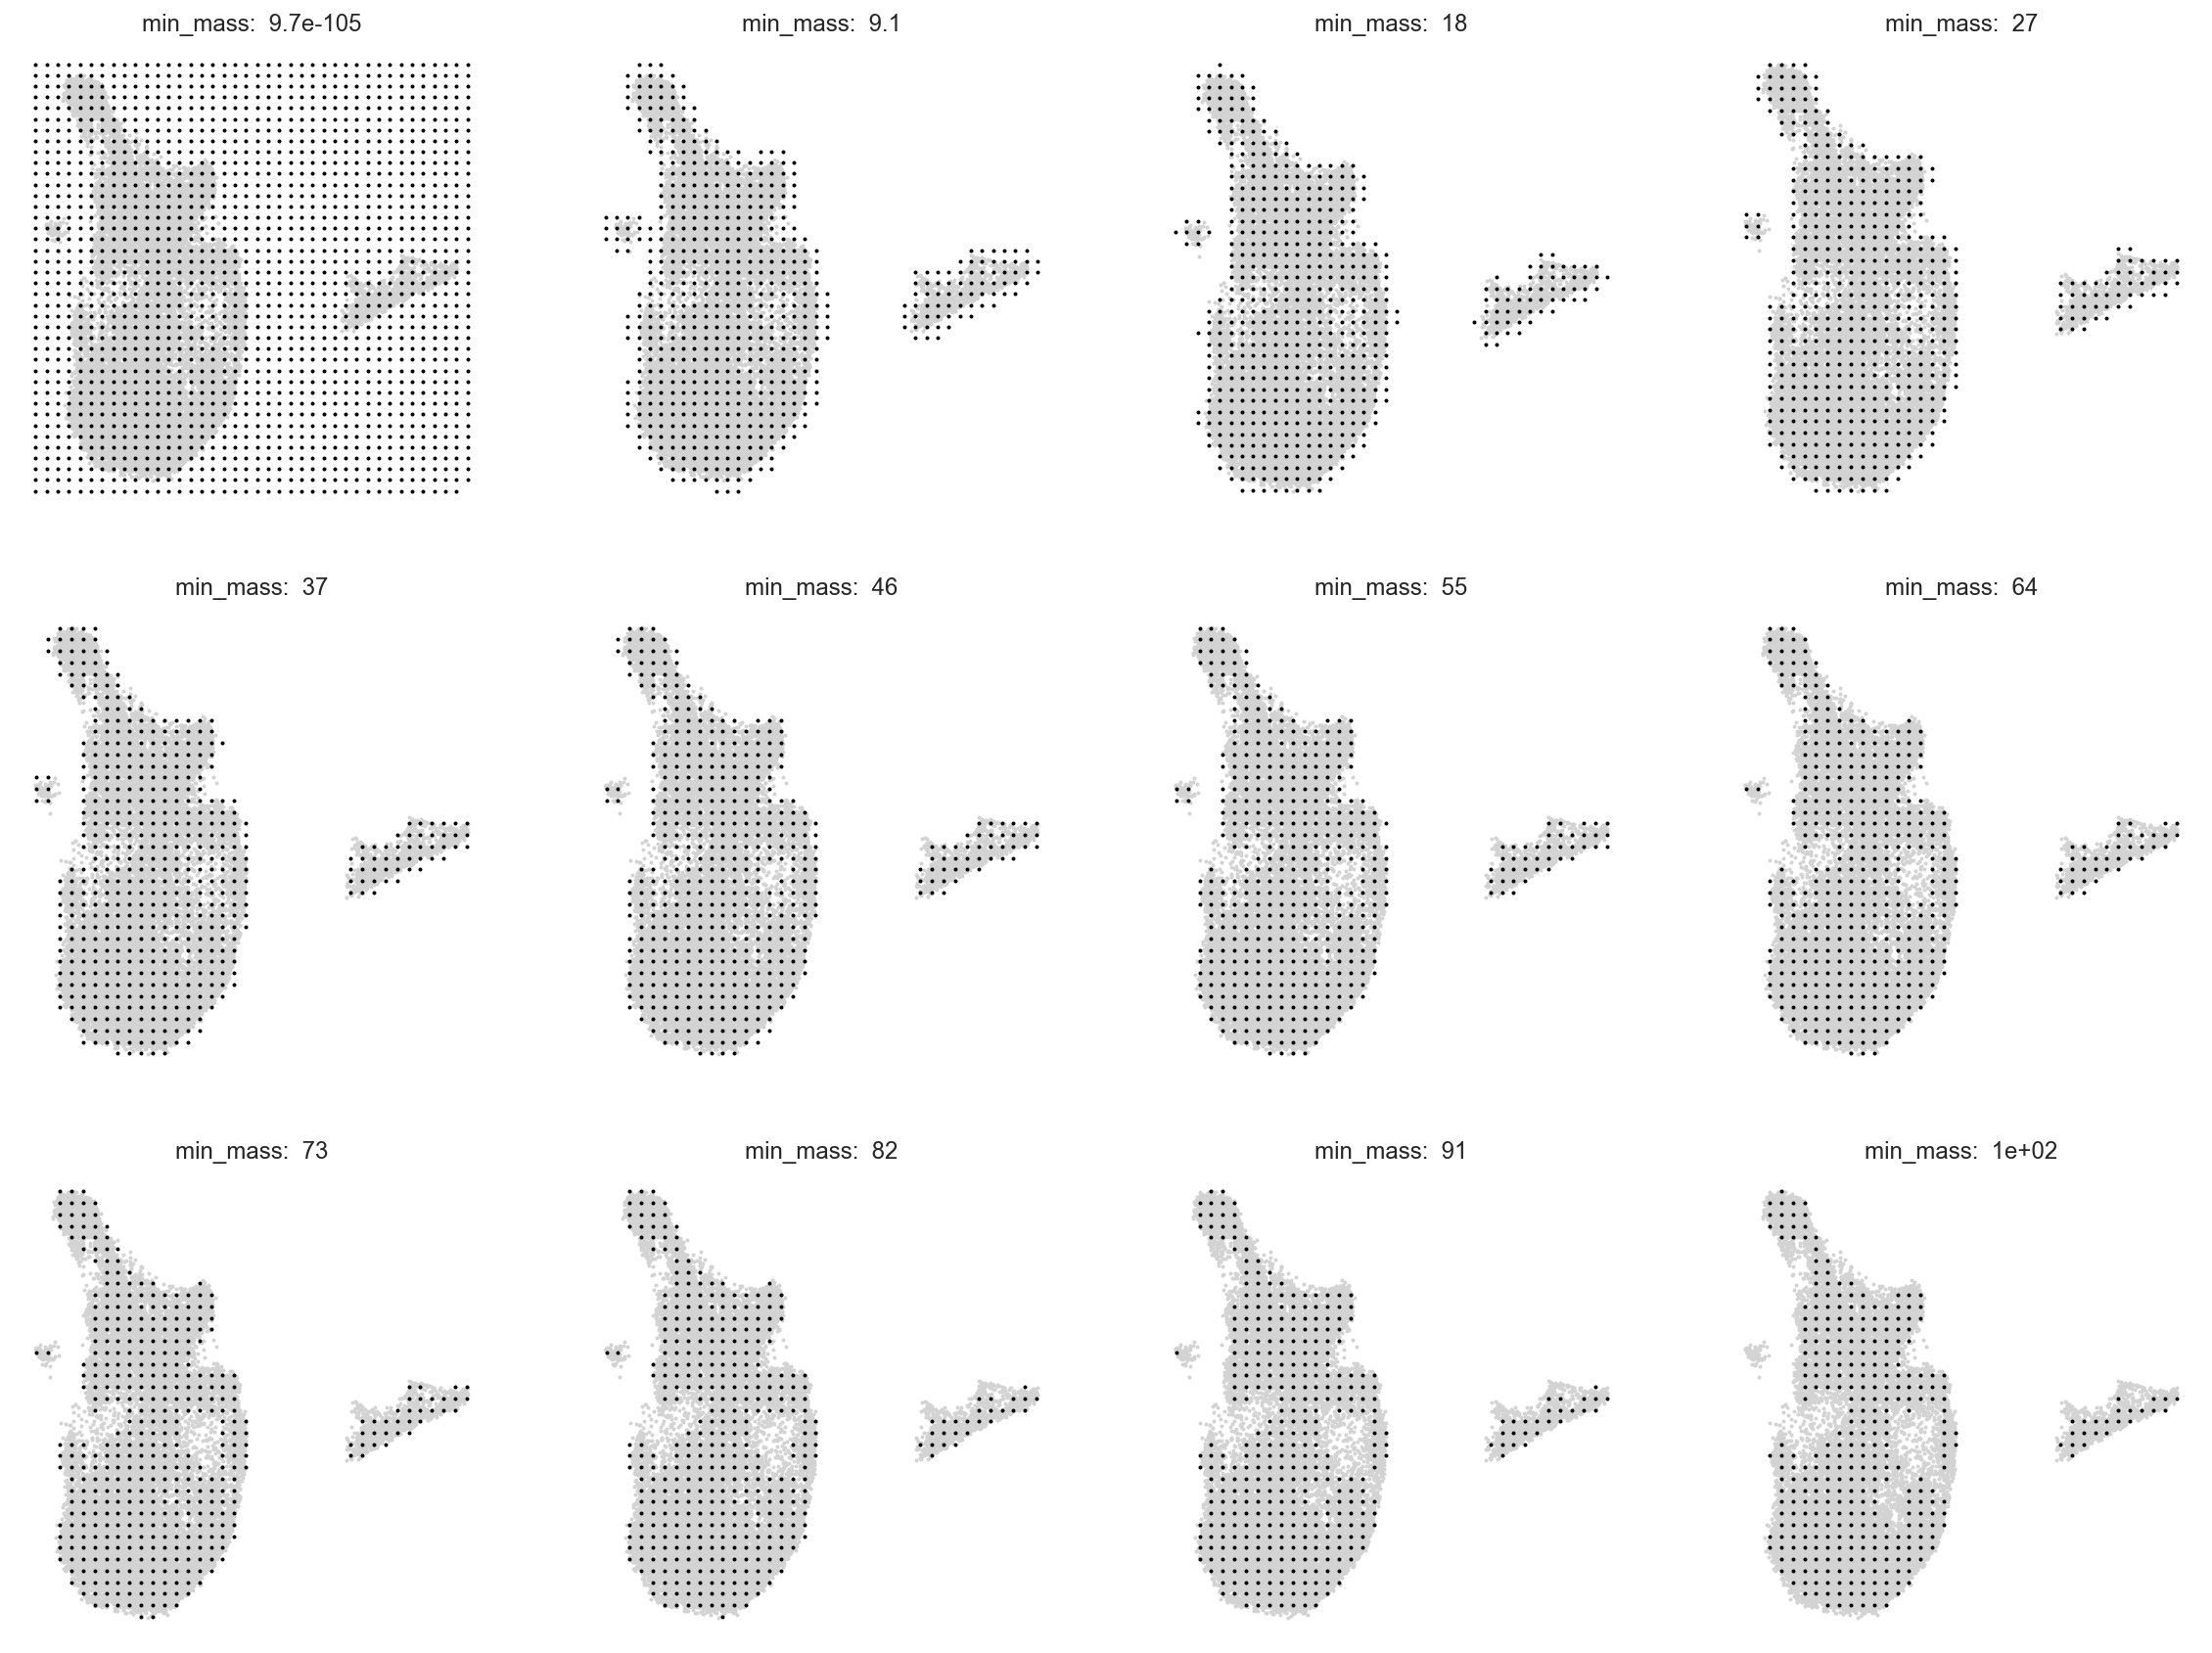

In [26]:
# Search for best min_mass.
oracle.suggest_mass_thresholds(n_suggestion=12)

According to the results, the optimal `min_mass` is around 0.011.

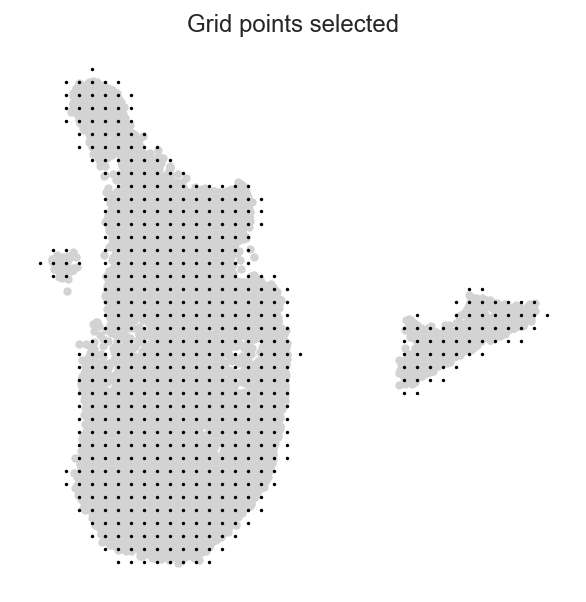

In [27]:
min_mass = 20
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

### 4.2.2  Plot vector fields

- Again, we need to adjust the `scale` parameter. Please seek to find the optimal `scale` parameter that provides good visualization.

- If you don't see any vector, you can try the smaller `scale` parameter to magnify the vector length. However, if you see large vectors in the randomized results (right panel), it means the scale parameter is too small.



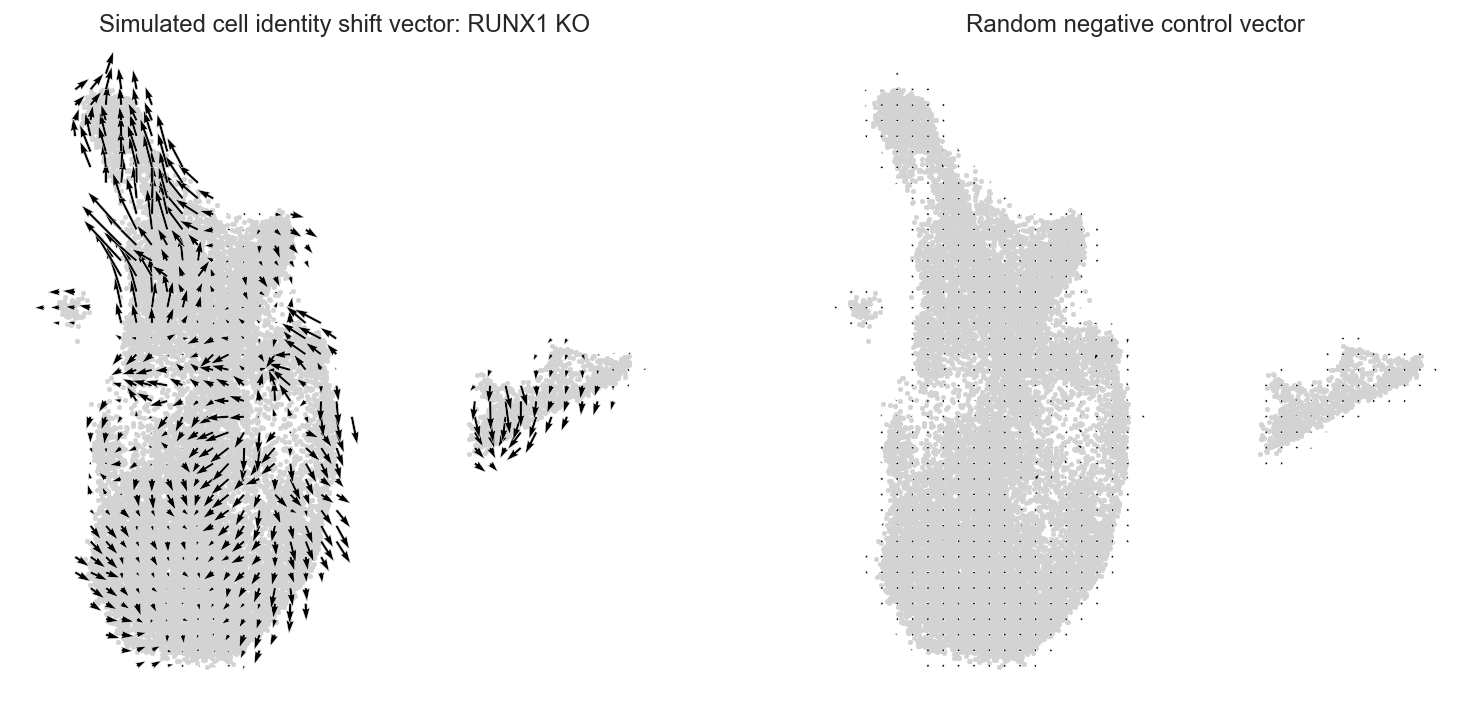

In [28]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 7
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Random negative control vector")

plt.savefig("RUNX1_KO_simulation_vector_field.pdf")

plt.show()

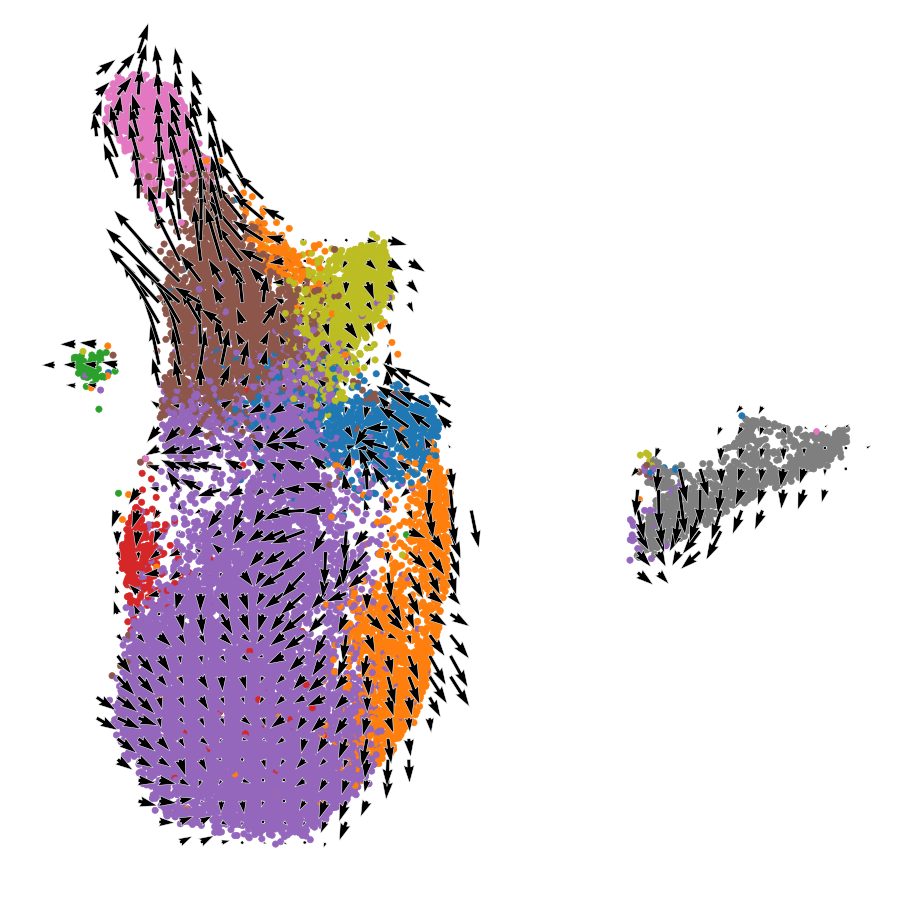

In [29]:
# Plot vector field with cell cluster 
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)

plt.savefig("RUNX1_KO_simulation_vector_field_on_cluster_color.pdf")

In [18]:
adata = oracle.adata

In [19]:
adata

AnnData object with n_obs × n_vars = 20000 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.3', 'seurat_clusters', 'cell.type', 'condition', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.4', 'RNA_snn_res.0.5', 'RNA_snn_res.0.6', 'Fibro_z', 'Pericyte_z', 'SMC_z', 'SCT_snn_res.0.1', 'SCT_snn_res.0.2', 'SCT_snn_res.0.4', 'SCT_snn_res.0.5', 'active_ident', 'condition_and_celltype', 'umap_density_condition', 'n_counts'
    var: 'variable_gene', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators', 'isin_actve_regulators'
    uns: 'active_ident_colors', 'condition_colors', 'cell.type_colors', 'umap_density_condition_params', 'log1p'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'raw_count', 'normalized_count', 'imputed_count', 'simulation_input', 'simulated_count', 'delta_X'

In [20]:
import palantir

# Plotting and miscellaneous imports
import os
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [21]:
sc.pp.normalize_per_cell(adata)

In [22]:
sc.pp.highly_variable_genes(adata, n_top_genes=1500, flavor='cell_ranger')

In [23]:
sc.pp.pca(adata)

In [24]:
# Run diffusion maps
pca_projections = pd.DataFrame(adata.obsm['X_pca'], index=adata.obs_names)
dm_res = palantir.utils.run_diffusion_maps(pca_projections)

Determing nearest neighbor graph...


In [25]:
ms_data = palantir.utils.determine_multiscale_space(dm_res)
ms_data

0         1         2         3  \
TWCM-11-78_CCTTACGAGAGGTACC       0.114623 -0.029410  0.205036 -0.019076   
TWCM-13-168_CAGCTGGCAAGCGCTC      0.019223 -0.058779  0.256640 -0.041501   
H_ZC-11-292_AACTCAGCACCTTGTC      0.019214 -0.042469  0.259718 -0.045783   
TWCM-388-NR-pre_CATTATCGTAGGGACT -0.117326 -0.109230 -0.023583 -0.011599   
TWCM-190-R-pre_TACGGTACAATGTTGC   0.032059 -0.032283  0.248306 -0.046733   
...                                    ...       ...       ...       ...   
TWCM-410-NR-pre_TACCTATAGATCTGCT -0.138080 -0.164664 -0.066819 -0.025957   
TWCM-11-74_AAACGGGCAAAGCAAT      -0.135148 -0.070073 -0.052257  0.023448   
H_ZC-11-292_GGACGTCGTACATGTC     -0.087579 -0.076717  0.045154  0.033532   
TWCM-11-192_ACTGAACTCAGATAAG     -0.162542 -0.094495 -0.122613  0.020112   
TWCM-359-NR-pre_CGGCTAGCATAAGACA -0.158591 -0.150645 -0.118294 -0.011782   

                                         4         5         6         7  
TWCM-11-78_CCTTACGAGAGGTACC      -0.038292 -0.089873 -0.086823  0.022858  
TWCM-13-168_CAGCTGGCAAGCGCTC     -0.045164  0.025243 -0.113160 -0.105785  
H_ZC-11-292_AACTCAGCACCTTGTC     -0.053372 -0.001890  0.005744 -0.093433  
TWCM-388-NR-pre_CATTATCGTAGGGACT -0.012904  0.021154  0.019544 -0.043285  
TWCM-190-R-pre_TACGGTACAATGTTGC  -0.050965  0.019207 -0.000480 -0.043260  
...                                    ...       ...       ...       ...  
TWCM-410-NR-pre_TACCTATAGATCTGCT -0.023539  0.214404 -0.045453  0.097291  
TWCM-11-74_AAACGGGCAAAGCAAT       0.017995 -0.110200 -0.033457  0.070249  
H_ZC-11-292_GGACGTCGTACATGTC      0.019105 -0.109663 -0.061530  0.071884  
TWCM-11-192_ACTGAACTCAGATAAG      0.019667 -0.082511  0.001272  0.049361  
TWCM-359-NR-pre_CGGCTAGCATAAGACA -0.008863  0.119873  0.015031  0.024420  

[20000 rows x 8 columns]

In [26]:
adata.layers['MAGIC_imputed_data'] = palantir.utils.run_magic_imputation(adata, dm_res)

In [27]:
start_cell = 'TWCM-463-R-pre_TTTATGCCACAGAGGT'
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=600)

Sampling and flocking waypoints...
Time for determining waypoints: 0.013890282313028971 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found.

Time for shortest paths: 0.4863605976104736 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9958
Correlation at iteration 2: 0.9998
Correlation at iteration 3: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [28]:
lst = []
for i in list(pr_res.branch_probs.columns):
    print(adata.obs["cell.type"][i])
    lst.append(adata.obs["cell.type"][i])

pr_res.branch_probs.columns = lst
pr_res.branch_probs = pr_res.branch_probs.loc[:, lst]

Mac2
Mono2
Mono2
cDC2
Prolif
Mac5


In [29]:
umap = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs_names)

In [30]:
umap

0         1
TWCM-11-78_CCTTACGAGAGGTACC      -2.084960  3.886604
TWCM-13-168_CAGCTGGCAAGCGCTC      2.993911  1.982043
H_ZC-11-292_AACTCAGCACCTTGTC      0.184505  3.016683
TWCM-388-NR-pre_CATTATCGTAGGGACT -2.294571 -1.018308
TWCM-190-R-pre_TACGGTACAATGTTGC   0.536078  4.657311
...                                    ...       ...
TWCM-410-NR-pre_TACCTATAGATCTGCT  2.614148 -2.553780
TWCM-11-74_AAACGGGCAAAGCAAT       7.365625  0.149859
H_ZC-11-292_GGACGTCGTACATGTC      7.448527  0.098133
TWCM-11-192_ACTGAACTCAGATAAG      7.301969 -0.249052
TWCM-359-NR-pre_CGGCTAGCATAAGACA  1.887726 -3.493231

[20000 rows x 2 columns]

In [31]:
oracle.adata.obs = pd.DataFrame(pr_res.pseudotime)

In [32]:
pd.DataFrame(pr_res.pseudotime)

0
TWCM-11-78_CCTTACGAGAGGTACC       0.156782
TWCM-13-168_CAGCTGGCAAGCGCTC      0.377985
H_ZC-11-292_AACTCAGCACCTTGTC      0.387186
TWCM-388-NR-pre_CATTATCGTAGGGACT  0.282410
TWCM-190-R-pre_TACGGTACAATGTTGC   0.325451
...                                    ...
TWCM-410-NR-pre_TACCTATAGATCTGCT  0.454870
TWCM-11-74_AAACGGGCAAAGCAAT       0.102089
H_ZC-11-292_GGACGTCGTACATGTC      0.037506
TWCM-11-192_ACTGAACTCAGATAAG      0.198926
TWCM-359-NR-pre_CGGCTAGCATAAGACA  0.381236

[20000 rows x 1 columns]

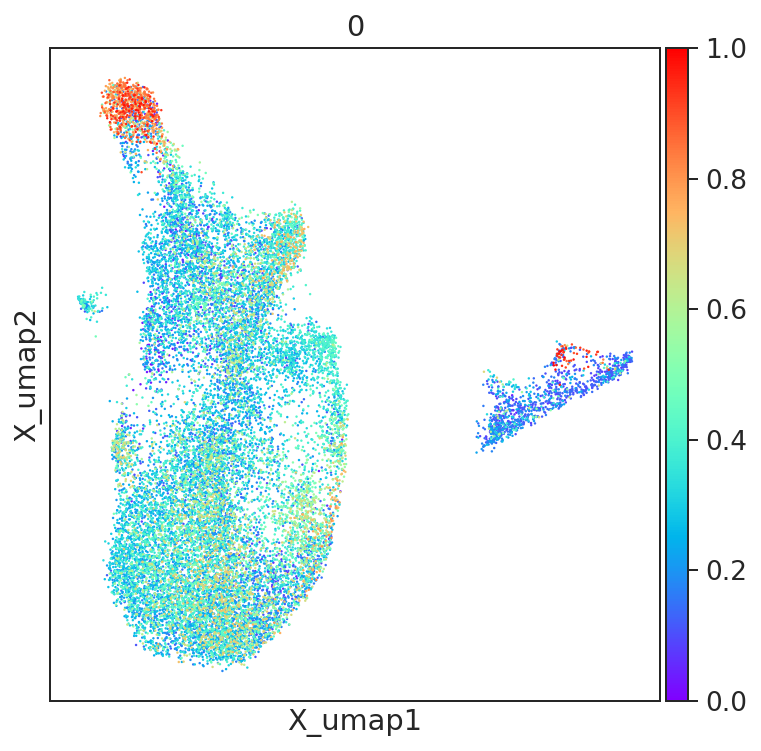

In [33]:
# Visualize pseudotime
fig, ax = plt.subplots(figsize=[6,6])

sc.pl.embedding(adata=oracle.adata, basis=oracle.embedding_name, ax=ax, cmap="rainbow",
                color=[0])

In [34]:
from celloracle.applications import Gradient_calculator

# Instantiate Gradient calculator object
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key=0)

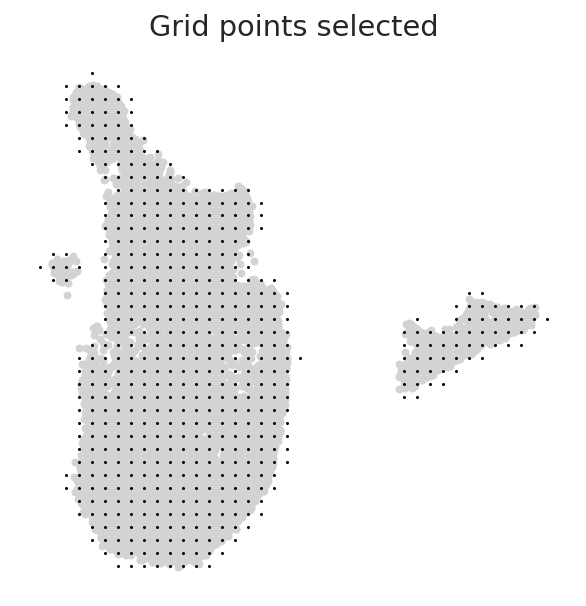

In [35]:
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)

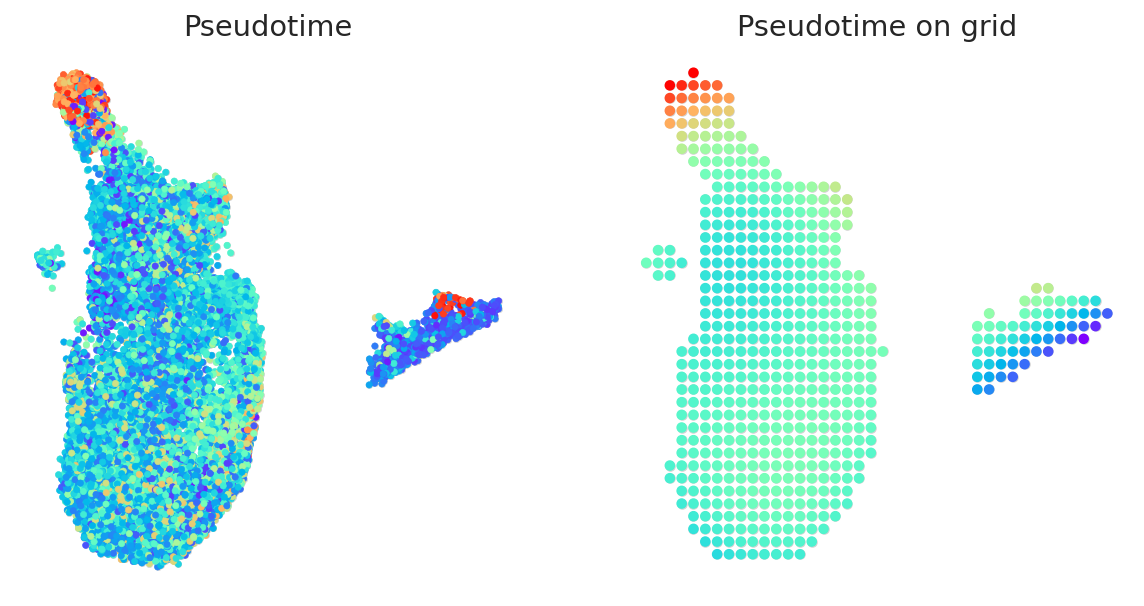

In [36]:
gradient.transfer_data_into_grid(args={"method": "polynomial", "n_poly":3}, plot=True)

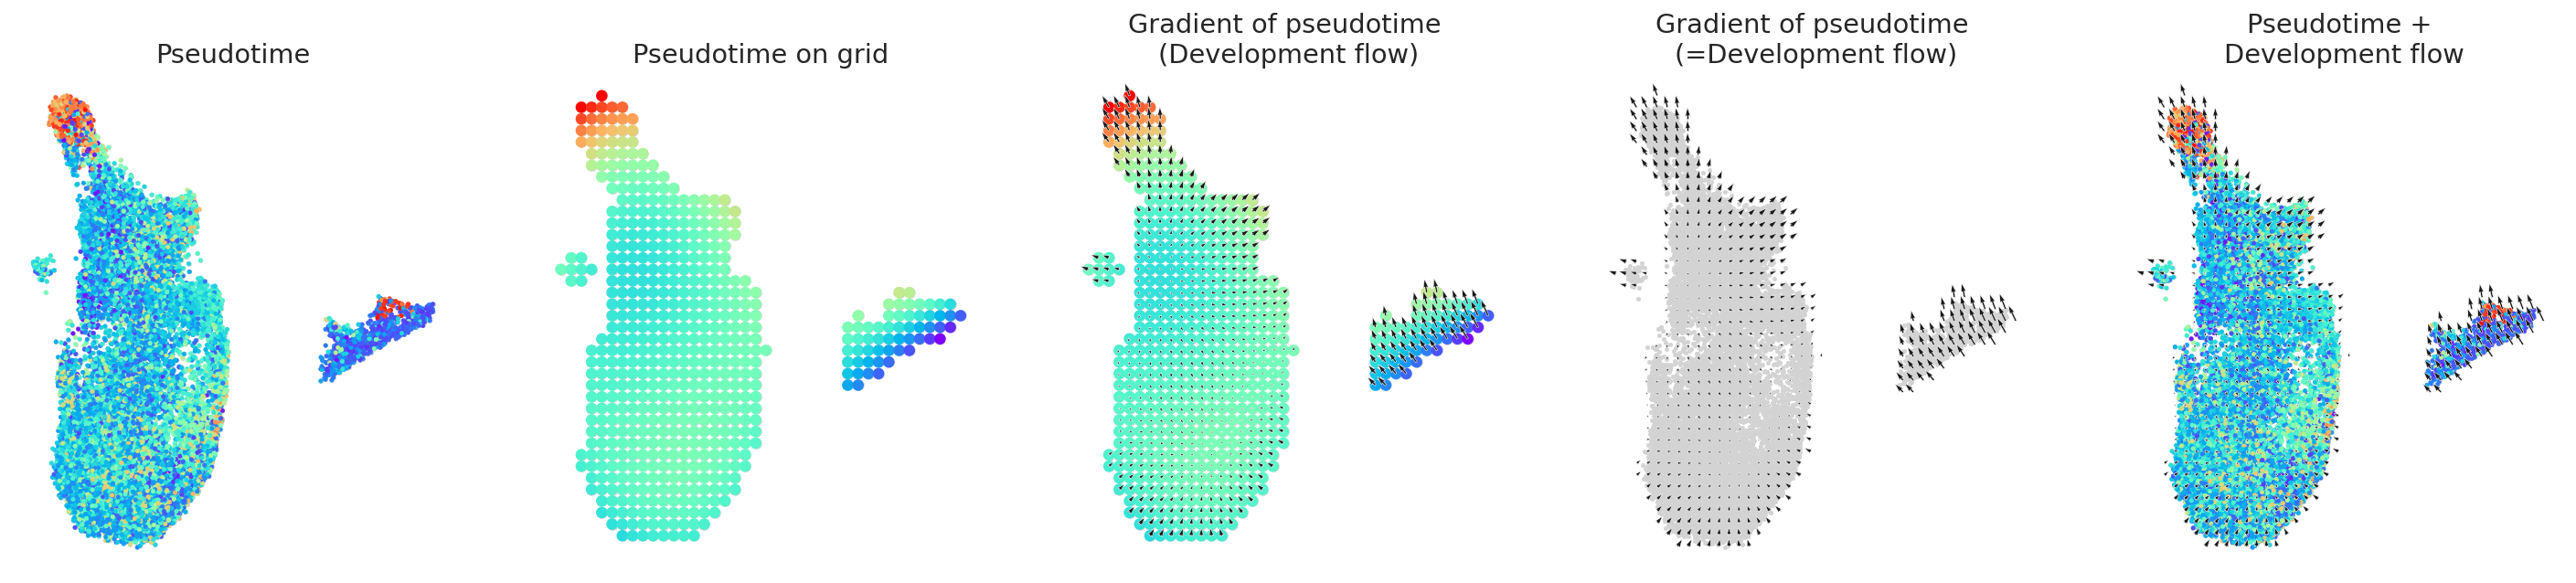

In [37]:
# Calculate graddient
gradient.calculate_gradient()

# Show results
scale_dev = 40
gradient.visualize_results(scale=scale_dev, s=5)

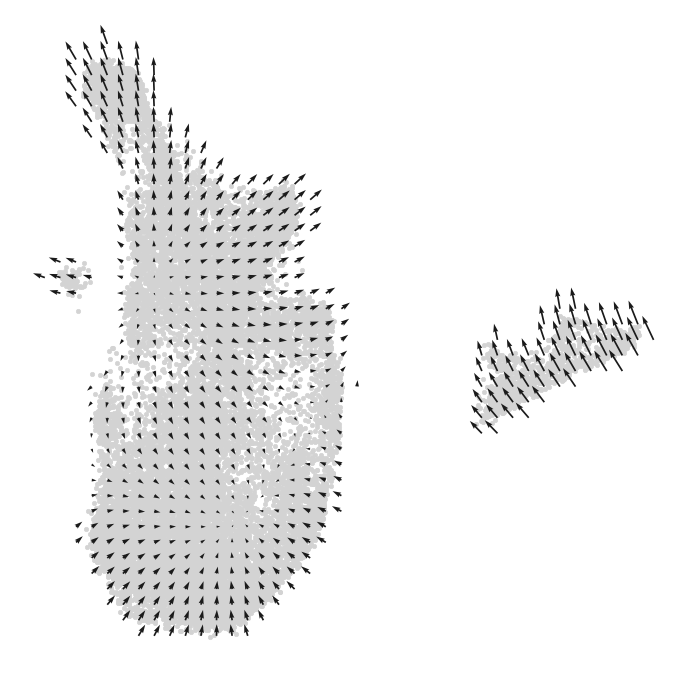

In [38]:
# Visualize results
fig, ax = plt.subplots(figsize=[6, 6])
gradient.plot_dev_flow_on_grid(scale=scale_dev, ax=ax)

In [30]:
gradient.to_hdf5("myeloid.developmentGradient.celloracle.gradient")

In [35]:
gradient = co.load_hdf5("myeloid.developmentGradient.celloracle.gradient")

In [36]:
from celloracle.applications import Oracle_development_module

# Make Oracle_development_module to compare two vector field
dev = Oracle_development_module()

# Load development flow
dev.load_differentiation_reference_data(gradient_object=gradient)

# Load simulation result
dev.load_perturb_simulation_data(oracle_object=oracle)


# Calculate inner produc scores
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)

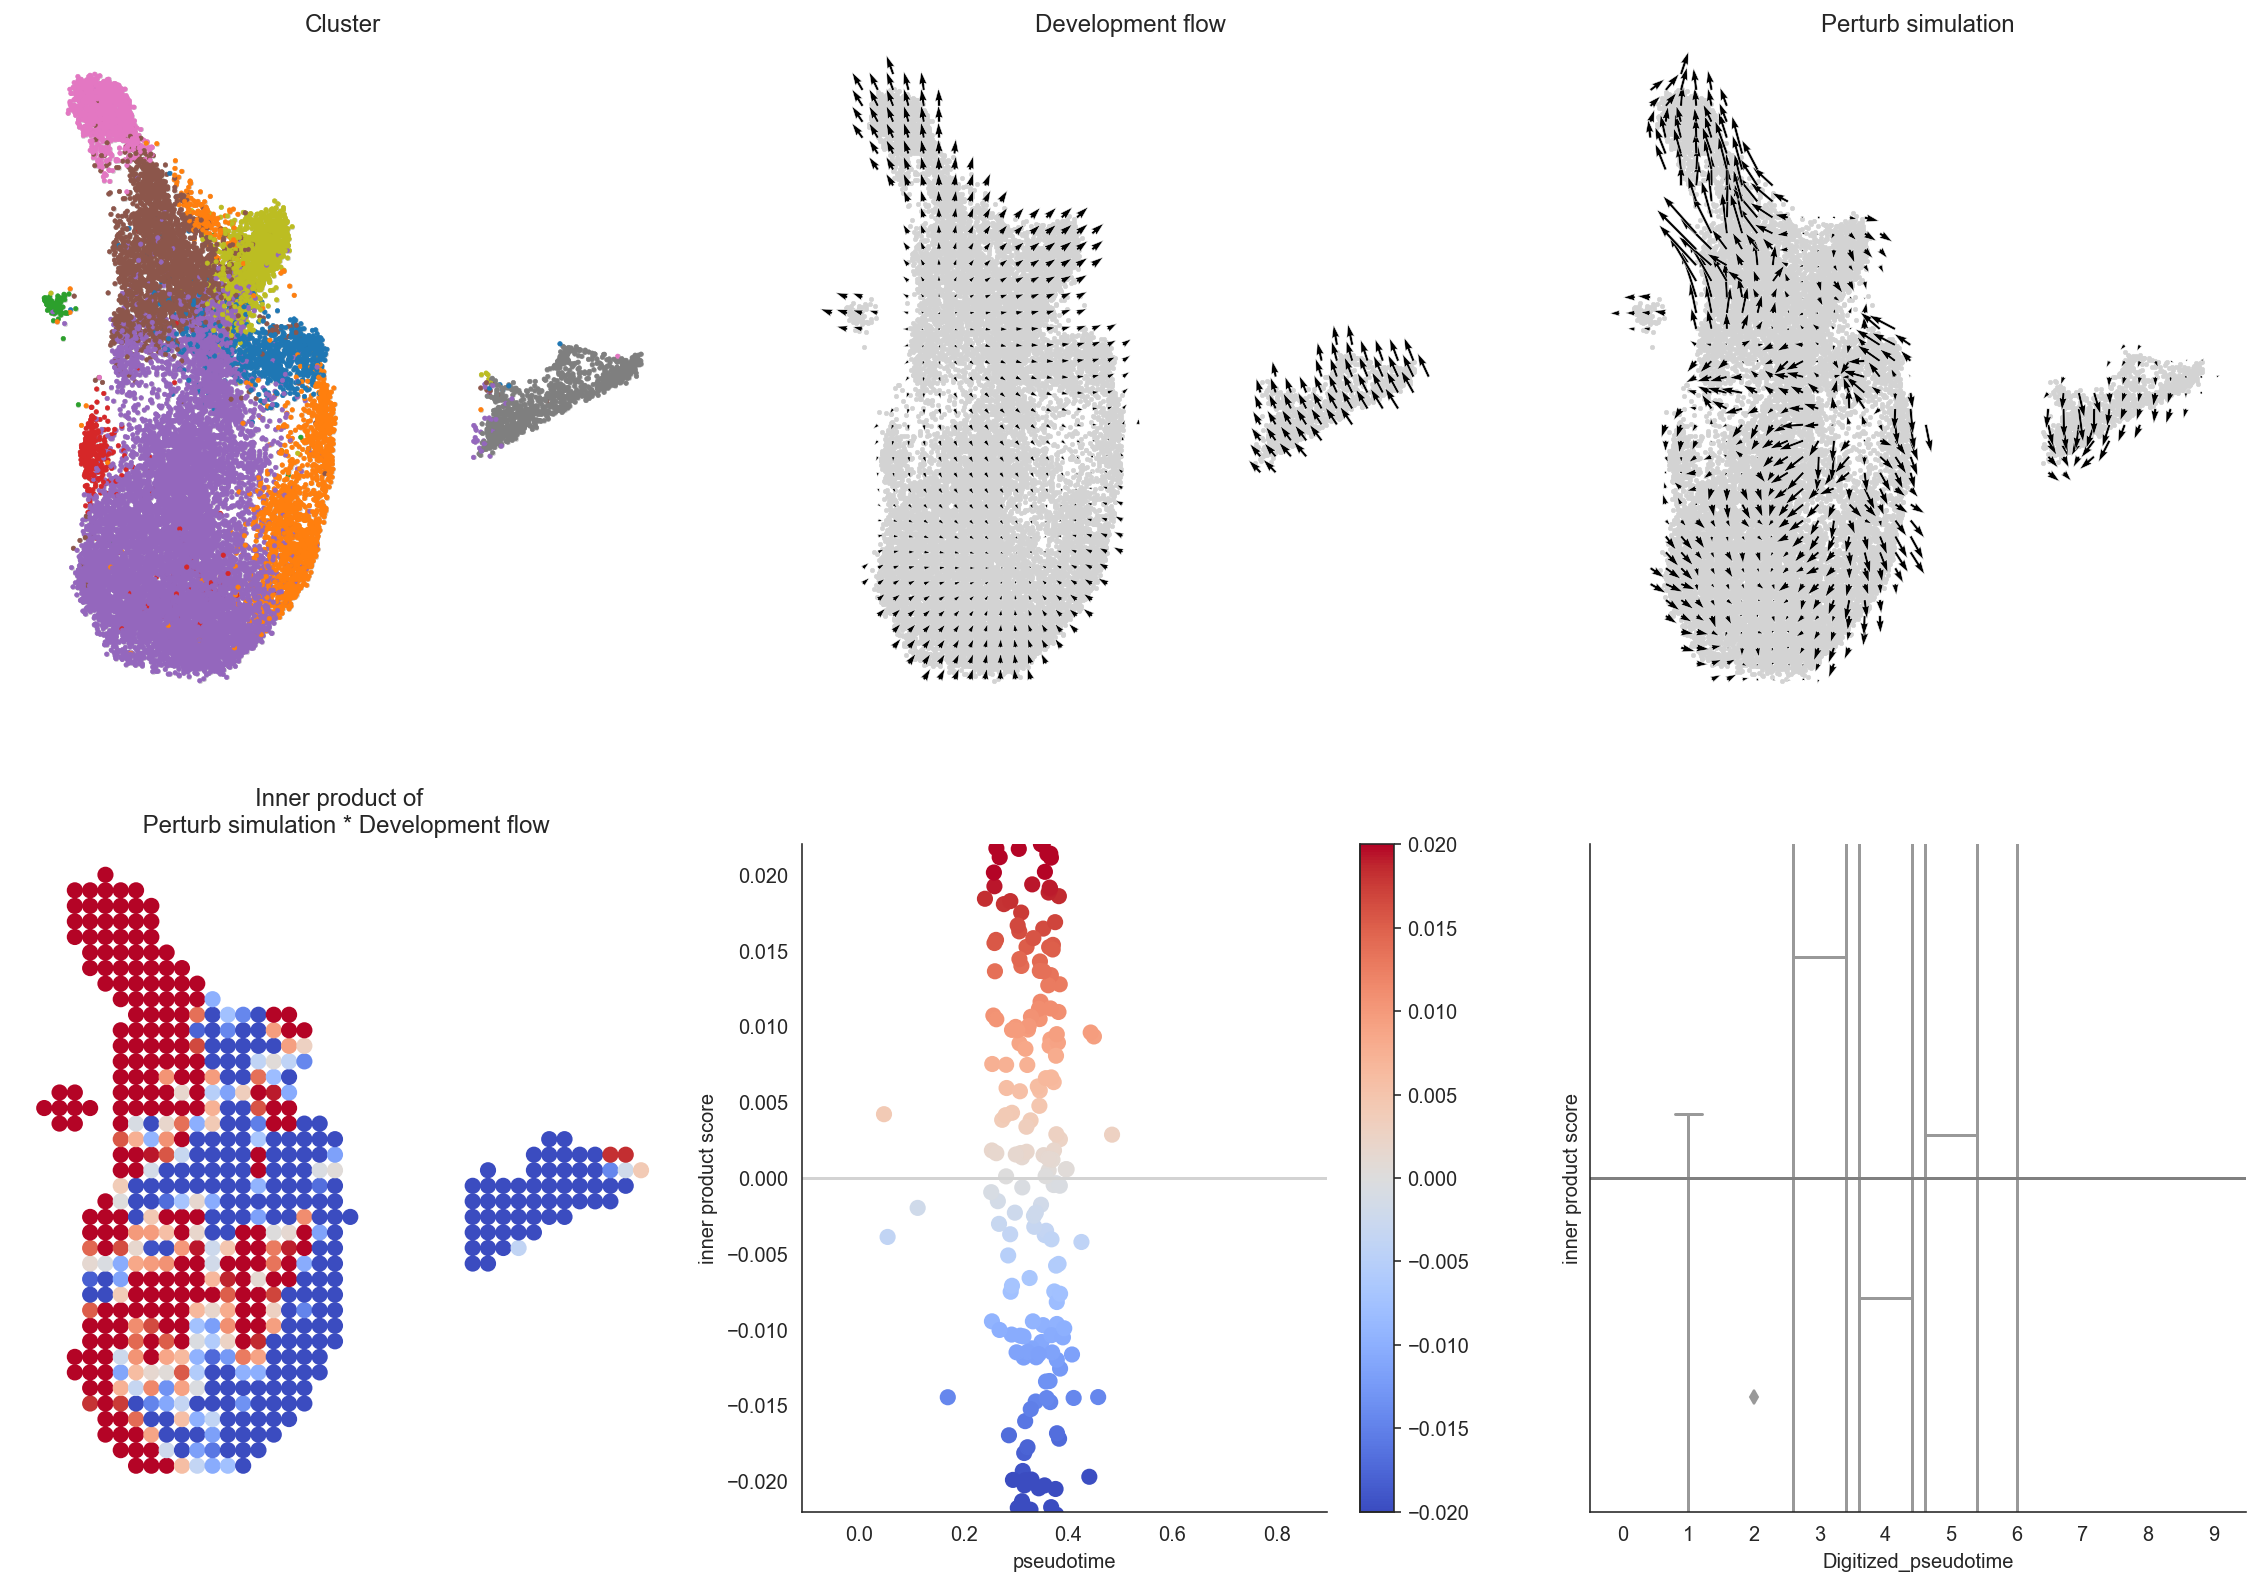

In [39]:
# Let's visualize the results
scale_simulation = 7
scale_dev = 40
dev.visualize_development_module_layout_0(s=5,
                                          scale_for_simulation=scale_simulation,
                                          s_grid=50,
                                          scale_for_pseudotime=scale_dev,
                                          vm=0.02)

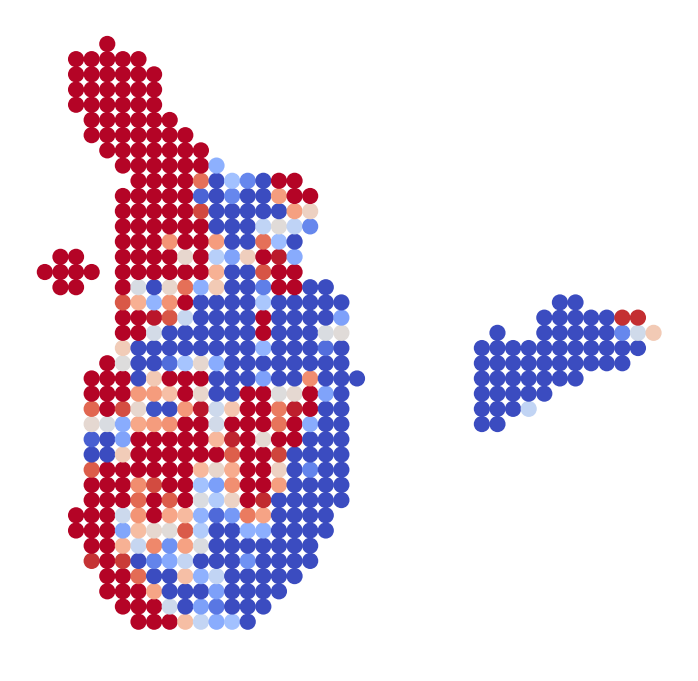

In [40]:
# Show perturbation scores
fig, ax = plt.subplots(figsize=[6, 6])
dev.plot_inner_product_on_grid(vm=0.02, s=50, ax=ax)

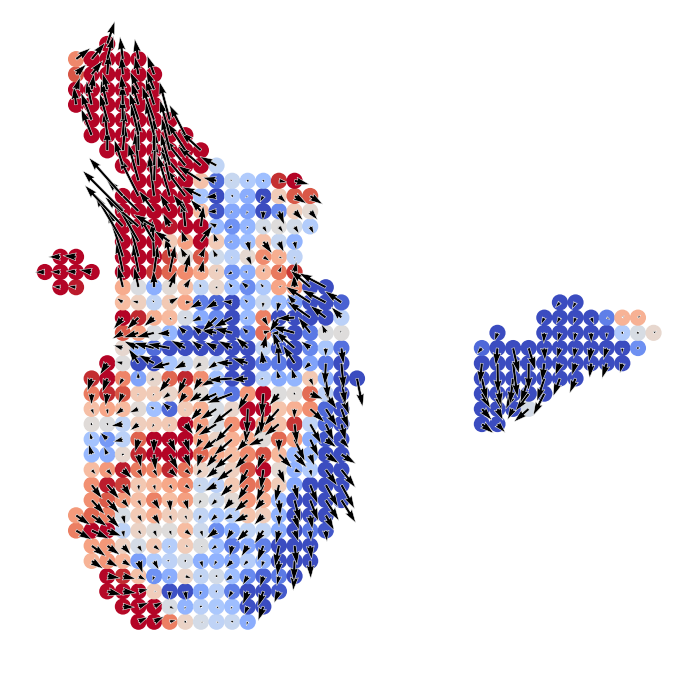

In [43]:
# Show perturbation scores with perturbation simulation vector field
fig, ax = plt.subplots(figsize=[6, 6])
dev.plot_inner_product_on_grid(vm=0.05, s=50, ax=ax)
dev.plot_simulation_flow_on_grid(scale=scale_simulation, show_background=False, ax=ax)
plt.savefig("RUNX1_KO_simulation_vector_field_dot_product.pdf")

In [38]:
from celloracle.visualizations.config import CONFIG
CONFIG["cmap_ps"] = "coolwarm"

In [70]:
dev.__dict__

{'_exemptions_when_del_attrs': [],
 'name': None,
 'cell_idx_use': None,
 'n_grid': 40,
 'min_mass': 20,
 'smooth': 0.8,
 'n_neighbors': 200,
 'pseudotime': array([0.15678193, 0.37798451, 0.38718618, ..., 0.03750567, 0.19892602,
        0.38123573]),
 'pseudotime_on_grid': array([0.03791372, 0.07113542, 0.10267748, ..., 3.24476946, 3.36350177,
        3.48137138]),
 'mass_filter_reference': array([ True,  True,  True, ...,  True,  True,  True]),
 'mass_filter_whole_reference': array([ True,  True,  True, ...,  True,  True,  True]),
 'gridpoints_coordinates': array([[-4.78457034, -6.1991321 ],
        [-4.36435439, -6.1991321 ],
        [-3.94413844, -6.1991321 ],
        ...,
        [10.76341982,  8.84410574],
        [11.18363577,  8.84410574],
        [11.60385172,  8.84410574]]),
 'ref_flow': array([[0.56343164, 0.80273608],
        [0.56371764, 0.7714411 ],
        [0.54837211, 0.74690443],
        ...,
        [0.96658982, 1.80545864],
        [0.9457372 , 1.85323489],
        [0

In [68]:
import seaborn as sns
sns.set_theme(style="whitegrid")

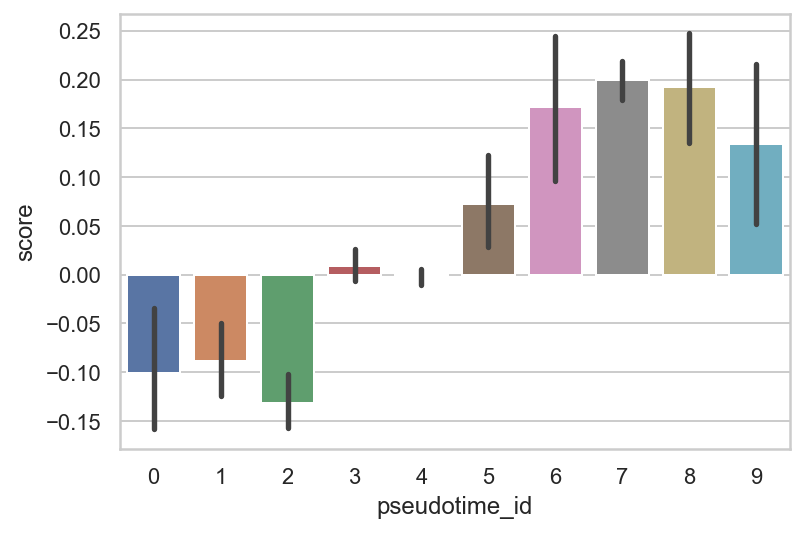

In [76]:
ax = sns.barplot(x="pseudotime_id", y="score", data=dev.inner_product_df)